# COURSE: A deep understanding of deep learning
## SECTION: More on data
### LECTURE: CodeChallenge: unbalanced data
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# A function to process the data by quality metric



In [3]:
# note: this is just old code copy/pasted here

def createAdataset(qualThreshold):

  # create a new column for binarized (boolean) quality
  data['boolQuality'] = 0


  
  # IMPORTANT: This is the main piece of this code!
  # in previous videos, qualThreshold was 5
  tmp = (data['quality']>qualThreshold ).astype(int)
  data['boolQuality'] = tmp # I also rewrote these lines from previous version to avoid the warning message



  # convert from pandas dataframe to tensor
  dataT  = torch.tensor( data[cols2zscore].values ).float()
  labels = torch.tensor( data['boolQuality'].values ).float()
  labels = labels[:,None] # transform to matrix

  # use scikitlearn to split the data
  train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = TensorDataset(train_data,train_labels)
  test_data  = TensorDataset(test_data,test_labels)

  # finally, translate into dataloader objects
  batchsize    = 8
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

  return train_loader,test_loader

In [4]:
# test the dataset and the number of samples

# note that the data are roughly balanced with thresh=5, not 4 or 6
train_loader,test_loader = createAdataset(6)

# get number of high/low quality wines
qualityRatings = train_loader.dataset.tensors[1].detach()
print('%s low-rated wines' %torch.sum(qualityRatings==0).item())
print('%s high-rated wines' %torch.sum(qualityRatings==1).item())

1236 low-rated wines
201 high-rated wines


# The DL parts: class for the model, and a function to train it

In [5]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.leaky_relu( self.input(x) )
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    return self.output(x)

In [6]:
### a function that trains the model

# global parameter
numepochs = 500

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [7]:
# create the data
train_loader,test_loader = createAdataset(5)

# create a model and train it
winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()

# compute accuracy per quality type
X,y = next(iter(test_loader))
yHat = winenet(X)
itemAccuracy = ((yHat>0) == y).float()

perQualAcc = [ 100*torch.mean(itemAccuracy[y==0]) ,
               100*torch.mean(itemAccuracy[y==1]) ]
perQualAcc

[tensor(76.3889), tensor(86.3636)]

# Now run the entire experiment!

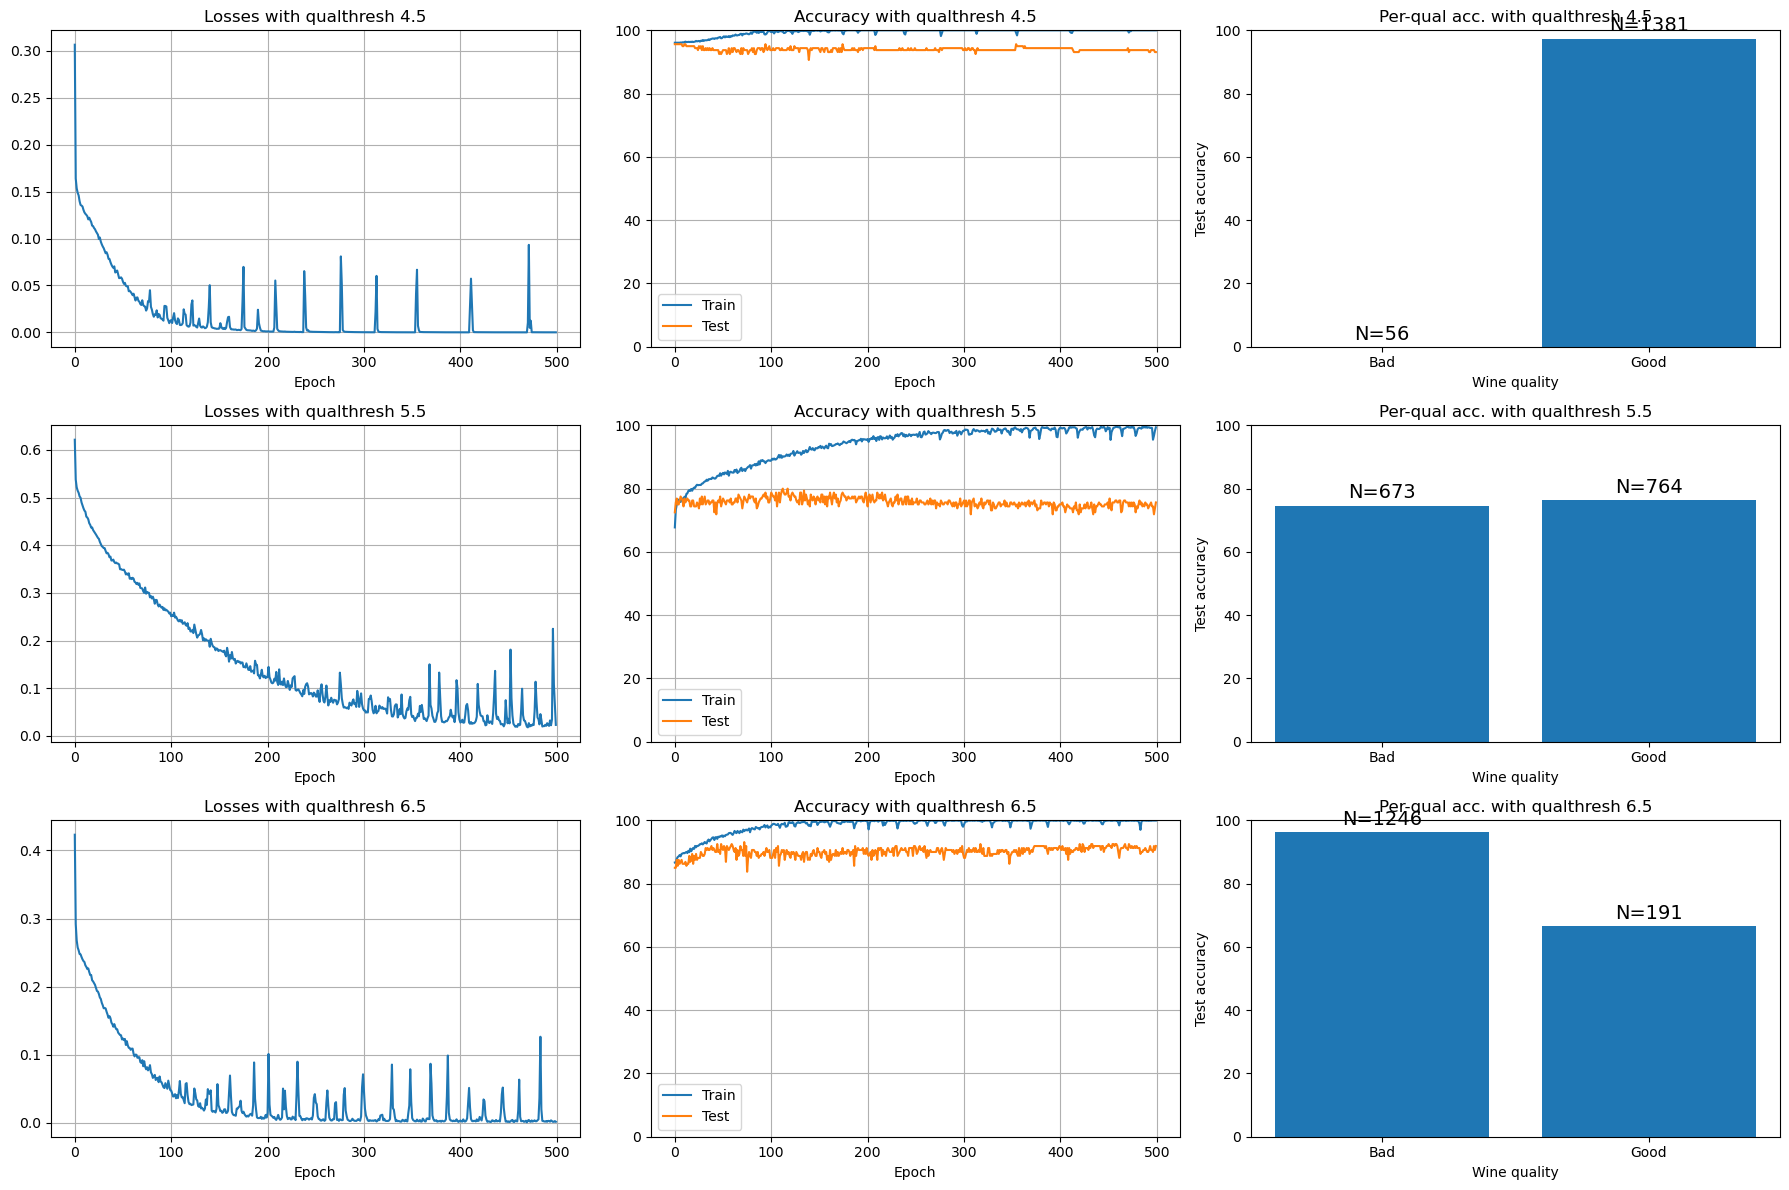

In [8]:
# note: this cell takes around 5 mins

# setup the figure
fig,ax = plt.subplots(3,3,figsize=(18,12))

# the quality thresholds
qualityThresholds = [4,5,6]


# loop over quality thresholds
for quali in range(len(qualityThresholds)):

  # create the data and model, and train it
  train_loader,test_loader = createAdataset( qualityThresholds[quali] )
  winenet = ANNwine()
  trainAcc,testAcc,losses = trainTheModel()

  # compute accuracy per quality type
  X,y = next(iter(test_loader))
  itemAccuracy = ((winenet(X)>0) == y).float()
  perQualAcc  = [ 100*torch.mean(itemAccuracy[y==0]) ,
                  100*torch.mean(itemAccuracy[y==1]) ]


  # plot losses
  ax[quali,0].plot(losses)
  ax[quali,0].set_title('Losses with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,0].set_xlabel('Epoch')
  ax[quali,0].grid()

  # plot overall accuracy
  ax[quali,1].plot(trainAcc,label='Train')
  ax[quali,1].plot(testAcc,label='Test')
  ax[quali,1].set_title('Accuracy with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,1].legend()
  ax[quali,1].set_xlabel('Epoch')
  ax[quali,1].set_ylim([0,100])
  ax[quali,1].grid()

  # plot the per-quality accuracy
  bh = ax[quali,2].bar(['Bad','Good'],perQualAcc)
  ax[quali,2].set_ylim([0,100])
  ax[quali,2].set_xlabel('Wine quality')
  ax[quali,2].set_ylabel('Test accuracy')
  ax[quali,2].set_title('Per-qual acc. with qualthresh ' + str(qualityThresholds[quali]+.5))

  # print the counts on top of each bar
  for i,r in enumerate(bh):
    N = torch.sum(train_loader.dataset.tensors[1]==i).item()
    ax[quali,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
              'N=%s'%N, ha='center', va='bottom', fontsize=14)


plt.tight_layout()
plt.show()

# Additional explorations

In [9]:
# 1) L2 regularization is supposed to help minimize over-training. Try adding an L2 regularizer and see if that
#    helps reduce the bias due to unbalanced N.
# 
# 2) Does the unbalanced design get better (that is, less unbalanced) if the train/test split is 80/20 instead of 90/10?
#    Try it and find out! Note that you don't need to train models for this question; you simply need to modify the data
#    splitting function and then compute the proportions of the two categories.
# 